In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

import gym
import torch
import d4rl
import tqdm


No module named 'flow'
/home/jlr429/miniconda3/envs/orl/lib/python3.9/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
pybullet build time: Dec  1 2021 18:34:28


In [2]:
env_name = "antmaze-large-diverse-v2"

In [3]:
def foo(env_name):
    env = gym.make(env_name)
    dataset = env.get_dataset()
    term = np.argwhere(
        np.logical_or(dataset["timeouts"] > 0, dataset["terminals"] > 0)
    )
    start = 0
    expert_ranges = []
    for i in range(len(term)):
        expert_ranges.append([start, term[i][0] + 1])
        start = term[i][0] + 1
    expert_ranges = np.array(expert_ranges)
    obs_start = []
    obs_end = []
    goals = []
    for exp_range in expert_ranges:
        obs_start.append(dataset["observations"][exp_range[0]])
        obs_end.append(dataset["observations"][exp_range[1] - 1])
        goals.append(dataset["infos/goal"][exp_range[0]])

    return dataset["observations"], obs_start, obs_end, np.array(goals)

    

In [4]:
# env_name = "antmaze-large-diverse-v2"
env_name = "antmaze-large-play-v2"
observation, obs_start, obs_end, goals = foo(env_name)
# observation = observation[:1000]
# obs_start = obs_start[:1000]
# obs_end = obs_end[:1000]
# goals = goals[:1000]

# get x, y from observations
x = observation[:, 0]
y = observation[:, 1]

# plot goal on top of density plot
gx, gy = goals[:, 0], goals[:, 1]

obs_start, obs_end = np.array(obs_start), np.array(obs_end)
start_x, start_y = obs_start[:, 0], obs_start[:, 1]
end_x, end_y = obs_end[:, 0], obs_end[:, 1]

/home/jlr429/miniconda3/envs/orl/lib/python3.9/site-packages/gym/spaces/box.py:78: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Target Goal:  (32.72483909874939, 24.767271807202192)


load datafile:   0%|          | 0/8 [00:00<?, ?it/s]

load datafile: 100%|██████████| 8/8 [00:02<00:00,  3.15it/s]


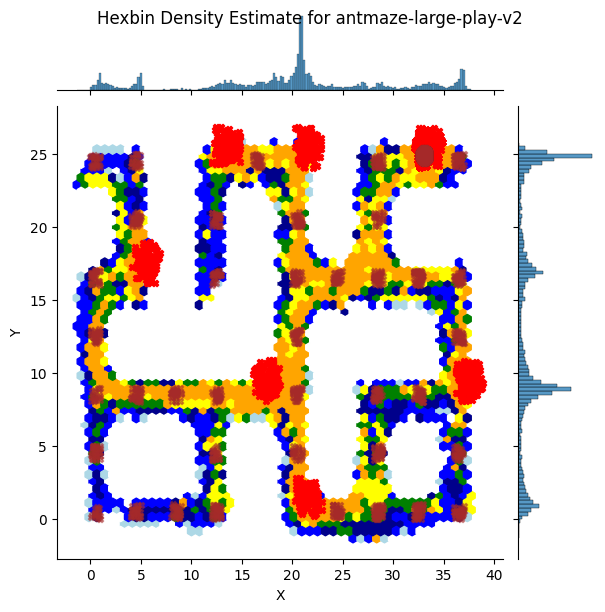

In [5]:
import matplotlib.colors as mcolors

# Define a custom colormap with distinct colors for different density levels
cmap = mcolors.ListedColormap(['white', 'lightblue', 'blue', 'darkblue', 'green', 'yellow', 'orange'])
bounds = [0, 5, 10, 50, 100, 200, 500, np.inf]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Uncomment the following lines if you want to add scatter plots for goal, start, and end points
g = sns.jointplot(x=x, y=y, kind="hex", gridsize=50, cmap=cmap, norm=norm)
# g = sns.jointplot(x=x, y=y, kind="hex", gridsize=50)
plt.scatter(gx, gy, color="red", s=20, marker="X")
plt.scatter(start_x, start_y, color="brown", s=20, marker="X", alpha=0.5)
# plt.scatter(end_x, end_y, color="orange", s=20, marker="X", alpha=0.5)

g.fig.suptitle(f"Hexbin Density Estimate for {env_name}")
g.set_axis_labels("X", "Y")
# g.fig.savefig(f"{env_name}_hexbin.png")

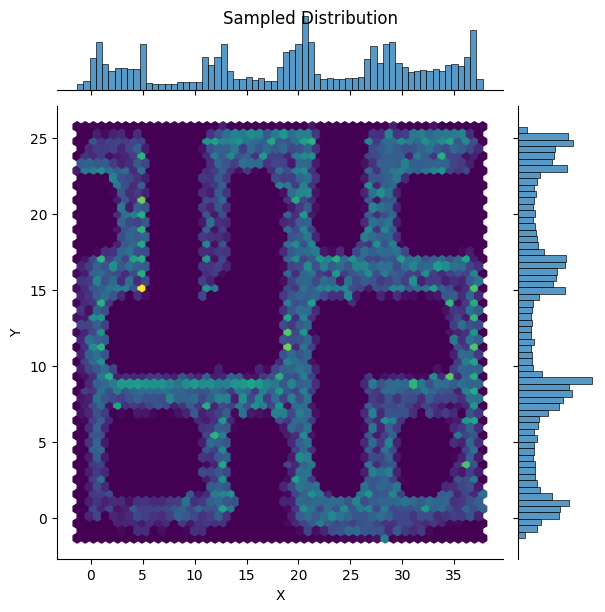

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 2D histogram with the same binning as the hexbin plot
hist, xedges, yedges = np.histogram2d(x, y, bins=50)

# Digitize the data points
x_dig = np.digitize(x, xedges) - 1
y_dig = np.digitize(y, yedges) - 1

# Ensure the indices are within the valid range
x_dig = np.clip(x_dig, 0, hist.shape[0] - 1)
y_dig = np.clip(y_dig, 0, hist.shape[1] - 1)

# Identify the bins with probability mass
bins_with_mass = np.argwhere(hist > 0)

# Calculate the total number of samples and the number of samples per bin
total_samples = int(0.2 * len(x))
num_bins = len(bins_with_mass)
samples_per_bin = total_samples // num_bins

# For each bin with mass, sample uniformly from the data points within that bin
sampled_x = []
sampled_y = []
for bin_x, bin_y in bins_with_mass:
    bin_mask = (x_dig == bin_x) & (y_dig == bin_y)
    bin_data_x = x[bin_mask]
    bin_data_y = y[bin_mask]
    num_samples = min(samples_per_bin, len(bin_data_x))
    data_indices = np.random.choice(len(bin_data_x), size=num_samples, replace=False)
    sampled_x.extend(bin_data_x[data_indices])
    sampled_y.extend(bin_data_y[data_indices])

# If there are not enough samples, sample more from the bins with mass
while len(sampled_x) < total_samples:
    bin_index = np.random.choice(num_bins)
    bin_x, bin_y = bins_with_mass[bin_index]
    bin_mask = (x_dig == bin_x) & (y_dig == bin_y)
    bin_data_x = x[bin_mask]
    bin_data_y = y[bin_mask]
    if len(bin_data_x) > 0:
        data_index = np.random.choice(len(bin_data_x))
        sampled_x.append(bin_data_x[data_index])
        sampled_y.append(bin_data_y[data_index])

sampled_x = np.array(sampled_x)
sampled_y = np.array(sampled_y)

# Plot the sampled distribution
g = sns.jointplot(x=sampled_x, y=sampled_y, kind="hex", gridsize=50)
g.fig.suptitle("Sampled Distribution")
g.set_axis_labels("X", "Y")
plt.show()

In [17]:
len(sampled_x)

200000

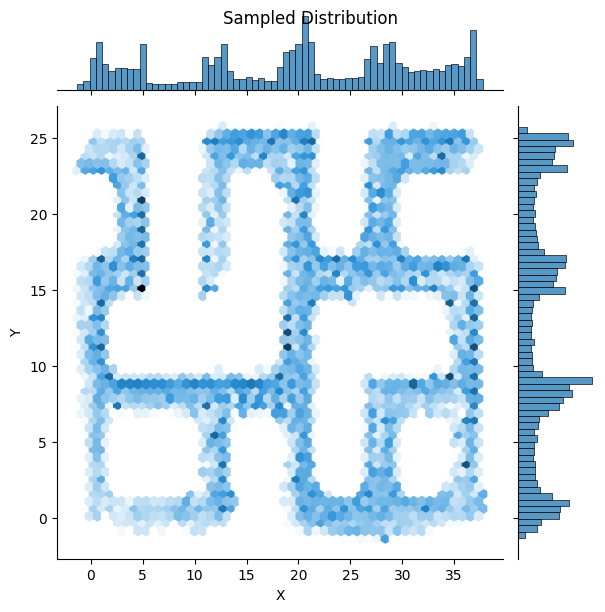

In [18]:
# Plot the sampled distribution
g = sns.jointplot(x=sampled_x, y=sampled_y, kind="hex", gridsize=50)
g.fig.suptitle("Sampled Distribution")
g.set_axis_labels("X", "Y")
plt.show()

In [22]:
# Create a mask for the sampled data points
sampled_mask = np.zeros(len(x), dtype=bool)
for i in range(len(sampled_x)):
    sampled_mask[np.where((x == sampled_x[i]) & (y == sampled_y[i]))[0][0]] = True

# Select the remaining data points
remaining_x = x[~sampled_mask]
remaining_y = y[~sampled_mask]

# Plot the remaining distribution
g = sns.jointplot(x=remaining_x, y=remaining_y, kind="hex", gridsize=50)
g.fig.suptitle("Remaining Distribution")
g.set_axis_labels("X", "Y")

plt.show()

KeyboardInterrupt: 

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def sample_data(x, y, bins=50, sample_ratio=0.2):
    # Create a 2D histogram with the same binning as the hexbin plot
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins)

    # Digitize the data points
    x_dig = np.digitize(x, xedges) - 1
    y_dig = np.digitize(y, yedges) - 1

    # Ensure the indices are within the valid range
    x_dig = np.clip(x_dig, 0, hist.shape[0] - 1)
    y_dig = np.clip(y_dig, 0, hist.shape[1] - 1)

    # Identify the bins with probability mass
    bins_with_mass = np.argwhere(hist > 0)

    # Calculate the total number of samples and the number of samples per bin
    total_samples = int(sample_ratio * len(x))
    num_bins = len(bins_with_mass)
    samples_per_bin = total_samples // num_bins

    # Create a dictionary to store the indices of the data points in each bin
    bin_indices = defaultdict(list)
    for i, (bin_x, bin_y) in enumerate(zip(x_dig, y_dig)):
        bin_indices[(bin_x, bin_y)].append(i)

    # For each bin with mass, sample uniformly from the data points within that bin
    sampled_indices = []
    for bin_x, bin_y in bins_with_mass:
        bin_data_indices = bin_indices[(bin_x, bin_y)]
        num_samples = min(samples_per_bin, len(bin_data_indices))
        sampled_indices.extend(np.random.choice(bin_data_indices, size=num_samples, replace=False))

    # If there are not enough samples, sample more from the bins with mass
    while len(sampled_indices) < total_samples:
        bin_index = np.random.choice(num_bins)
        bin_x, bin_y = bins_with_mass[bin_index]
        bin_data_indices = bin_indices[(bin_x, bin_y)]
        if len(bin_data_indices) > 0:
            sampled_indices.append(np.random.choice(bin_data_indices))

    # Create a mask for the sampled data points
    sampled_mask = np.zeros(len(x), dtype=bool)
    sampled_mask[sampled_indices] = True

    # Select the sampled and remaining data points
    sampled_x = x[sampled_mask]
    sampled_y = y[sampled_mask]
    remaining_x = x[~sampled_mask]
    remaining_y = y[~sampled_mask]

    return sampled_x, sampled_y, remaining_x, remaining_y

199453, 199453, 800547, 800547


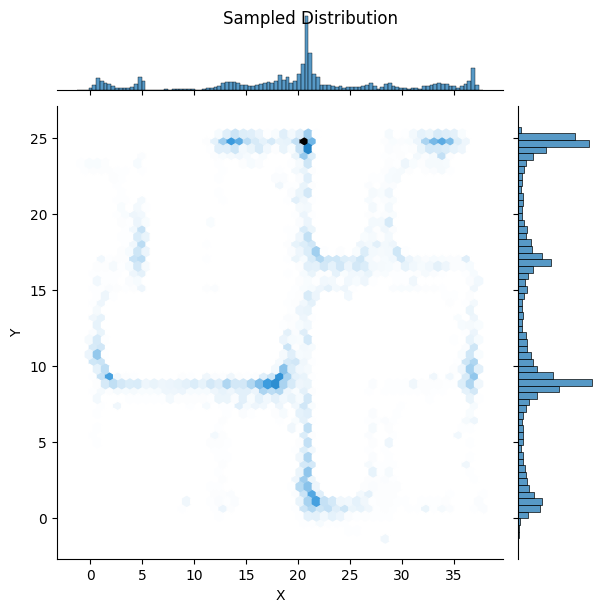

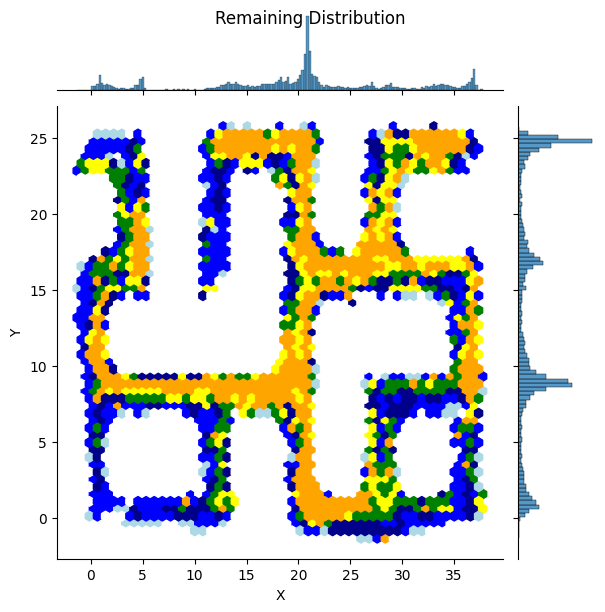

In [40]:
sampled_x, sampled_y, remaining_x, remaining_y = sample_data(x, y)
print(f"{len(sampled_x)}, {len(sampled_y)}, {len(remaining_x)}, {len(remaining_y)}")

# Plot the sampled distribution
g = sns.jointplot(x=sampled_x, y=sampled_y, kind="hex", gridsize=50)
g.fig.suptitle("Sampled Distribution")
g.set_axis_labels("X", "Y")

# Plot the remaining distribution
cmap = mcolors.ListedColormap(['white', 'lightblue', 'blue', 'darkblue', 'green', 'yellow', 'orange'])
bounds = [0, 5, 10, 50, 100, 200, 500, np.inf]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
g = sns.jointplot(x=remaining_x, y=remaining_y, kind="hex", gridsize=50, cmap=cmap, norm=norm)
g.fig.suptitle("Remaining Distribution")
g.set_axis_labels("X", "Y")

plt.show()

In [33]:
def sample_data(x, y, bins=50, sample_ratio=0.2):
    # Create a 2D histogram with the same binning as the hexbin plot
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins)

    # Digitize the data points
    x_dig = np.digitize(x, xedges) - 1
    y_dig = np.digitize(y, yedges) - 1

    # Ensure the indices are within the valid range
    x_dig = np.clip(x_dig, 0, hist.shape[0] - 1)
    y_dig = np.clip(y_dig, 0, hist.shape[1] - 1)

    # Create a dictionary to store the indices of the data points in each bin
    bin_indices = defaultdict(list)
    for i, (bin_x, bin_y) in enumerate(zip(x_dig, y_dig)):
        bin_indices[(bin_x, bin_y)].append(i)

    # For each bin, sample a certain ratio of the data points
    sampled_indices = []
    for bin_data_indices in bin_indices.values():
        num_samples = int(len(bin_data_indices) * sample_ratio)
        sampled_indices.extend(np.random.choice(bin_data_indices, size=num_samples, replace=False))

    # Create a mask for the sampled data points
    sampled_mask = np.zeros(len(x), dtype=bool)
    sampled_mask[sampled_indices] = True

    # Select the sampled and remaining data points
    sampled_x = x[sampled_mask]
    sampled_y = y[sampled_mask]
    remaining_x = x[~sampled_mask]
    remaining_y = y[~sampled_mask]

    return sampled_x, sampled_y, remaining_x, remaining_y

199453, 199453, 800547, 800547


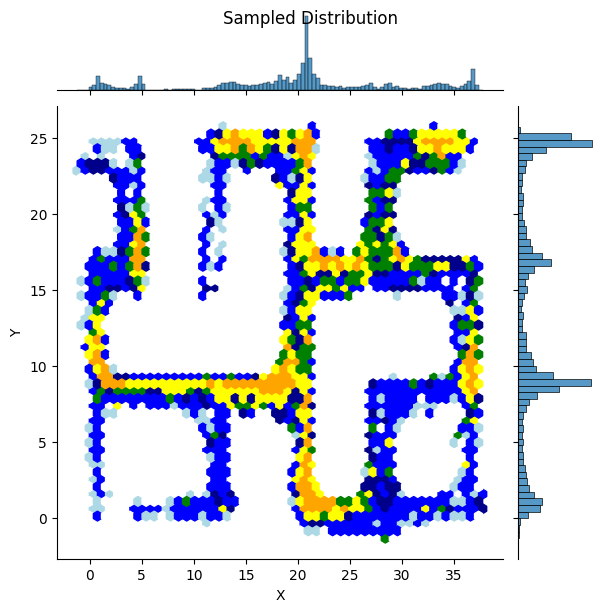

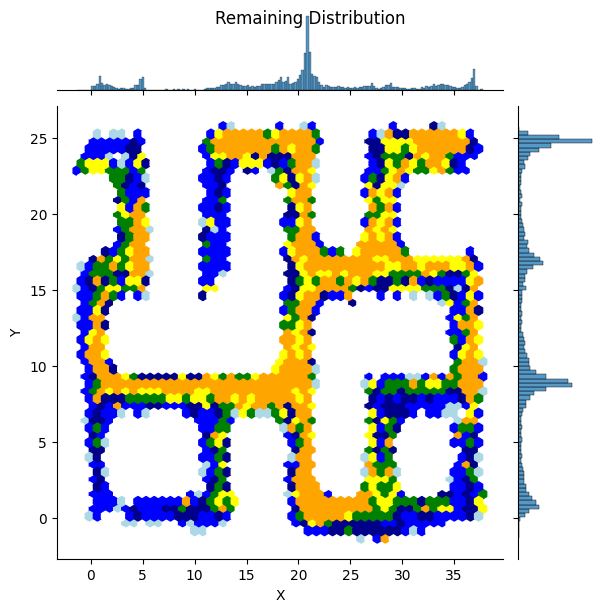

In [43]:
sampled_x, sampled_y, remaining_x, remaining_y = sample_data(x, y)
print(f"{len(sampled_x)}, {len(sampled_y)}, {len(remaining_x)}, {len(remaining_y)}")

# Define the colormap
cmap = plt.cm.viridis

# Define the bounds and normalize them to 25%
bounds = np.array([0, 5, 10, 50, 100, 200, 500, np.inf]) * 0.25
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the sampled distribution
g = sns.jointplot(x=sampled_x, y=sampled_y, kind="hex", gridsize=50, cmap=cmap, norm=norm)
g.fig.suptitle("Sampled Distribution")
g.set_axis_labels("X", "Y")

# Plot the remaining distribution
g = sns.jointplot(x=remaining_x, y=remaining_y, kind="hex", gridsize=50, cmap=cmap, norm=norm)
g.fig.suptitle("Remaining Distribution")
g.set_axis_labels("X", "Y")

plt.show()

In [60]:
def calculate_statistics(data_x, data_y):
    # Calculate the histogram
    hist, xedges, yedges = np.histogram2d(data_x, data_y, bins=50)

    # Filter out 0 values
    hist = hist[hist > 0]

    # Calculate the statistics
    data_min = np.min(hist)
    data_max = np.max(hist)
    data_median = np.median(hist)
    data_q1 = np.percentile(hist, 25)
    data_q3 = np.percentile(hist, 75)
    data_min_q1_median = np.median(hist[(hist >= data_min) & (hist <= data_q1)])
    data_q1_median = np.median(hist[(hist >= data_q1) & (hist <= data_median)])
    data_median_q3 = np.median(hist[(hist >= data_median) & (hist <= data_q3)])
    data_q3_max = np.median(hist[(hist >= data_q3) & (hist <= data_max)])

    # Return the statistics as a list
    return [data_min, data_min_q1_median, data_q1, data_q1_median, data_median, data_median_q3, data_q3, data_q3_max, data_max]

# # Calculate the statistics for sampled data
# sampled_data = calculate_statistics(sampled_x, sampled_y)
# print(f"Sampled data: {sampled_data}")

# # Calculate the statistics for remaining data
# remaining_data = calculate_statistics(remaining_x, remaining_y)
# print(f"Remaining data: {remaining_data}")

Sampled data: [1.0, 4.0, 9.0, 19.0, 35.0, 78.0, 160.0, 353.0, 5038.0]
Remaining data: [1.0, 9.0, 29.0, 63.0, 117.0, 250.0, 585.0, 1265.5, 21472.0]


199453, 199453, 800547, 800547


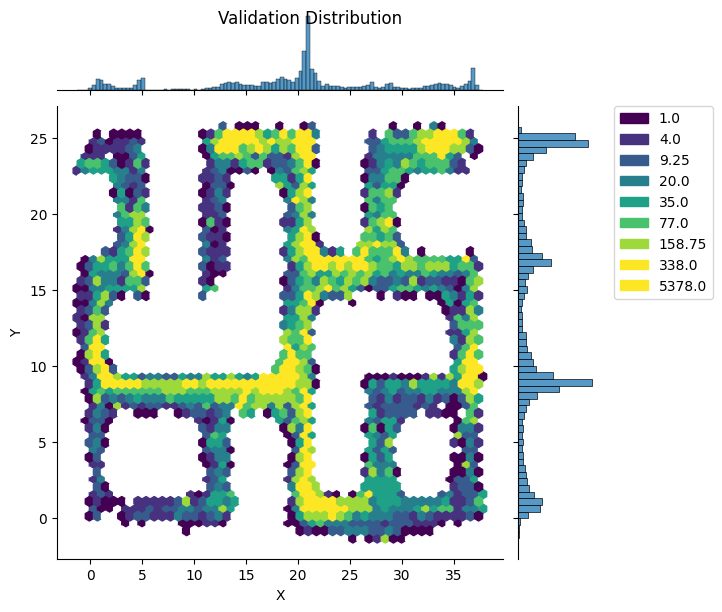

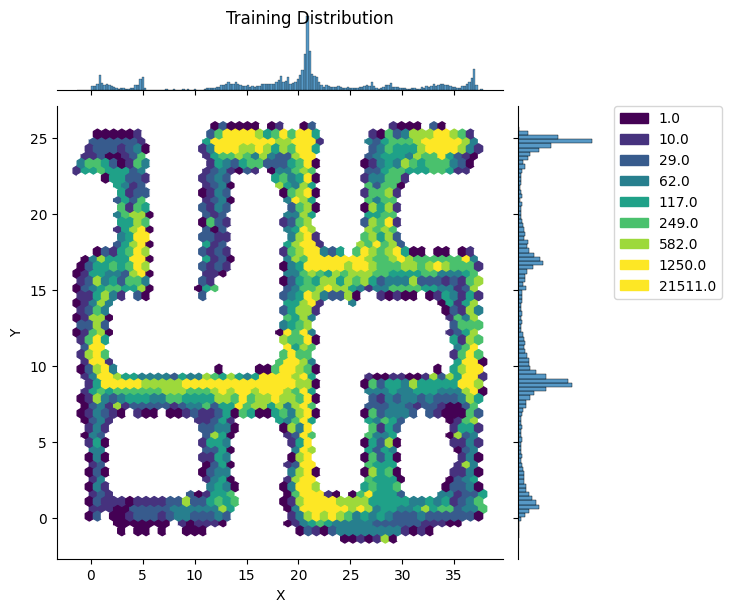

In [64]:
import matplotlib.patches as mpatches

val_x, val_y, train_x, train_y = sample_data(x, y)
print(f"{len(val_x)}, {len(val_y)}, {len(train_x)}, {len(train_y)}")

# Define the colormap
cmap = plt.cm.viridis

# Calculate statistics and plot for validation data
val_stats = calculate_statistics(val_x, val_y)
val_bounds = np.array(val_stats)
val_norm = mcolors.BoundaryNorm(val_bounds, cmap.N)

# Plot the sampled distribution
g = sns.jointplot(x=val_x, y=val_y, kind="hex", gridsize=50, cmap=cmap, norm=val_norm)
g.fig.suptitle("Validation Distribution")
g.set_axis_labels("X", "Y")

# Create a list of patches for the legend
patches = [mpatches.Patch(color=cmap(val_norm(stat)), label=stat) for stat in val_stats]

# Add the legend to the plot
plt.legend(handles=patches, bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0.)

# Calculate statistics and plot for training data
train_stats = calculate_statistics(train_x, train_y)
train_bounds = np.array(train_stats)
train_norm = mcolors.BoundaryNorm(train_bounds, cmap.N)

# Plot the remaining distribution
g = sns.jointplot(x=train_x, y=train_y, kind="hex", gridsize=50, cmap=cmap, norm=train_norm)
g.fig.suptitle("Training Distribution")
g.set_axis_labels("X", "Y")

# Create a list of patches for the legend
patches = [mpatches.Patch(color=cmap(train_norm(stat)), label=stat) for stat in train_stats]

# Add the legend to the plot
plt.legend(handles=patches, bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0.)

plt.show()

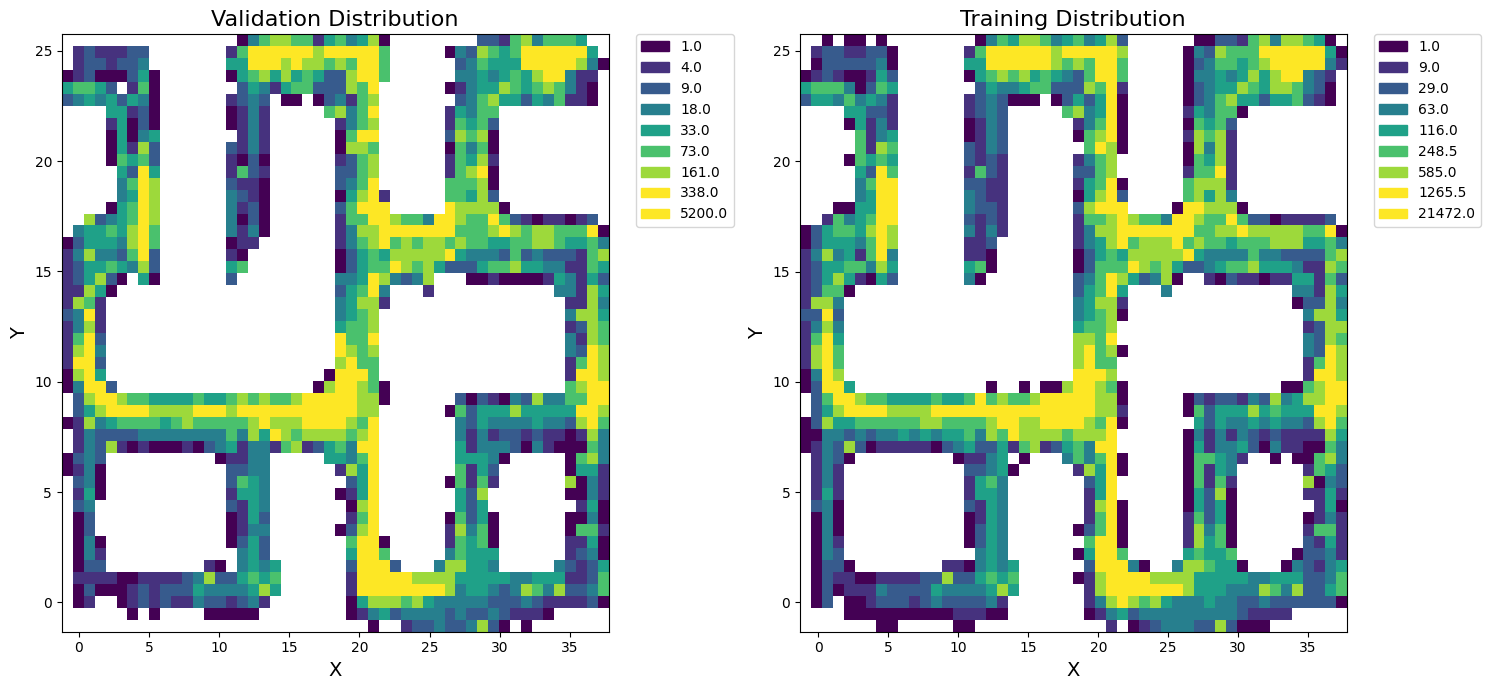

In [72]:
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

# Define the colormap
cmap = plt.cm.viridis

# Create a figure with two subplots side by side, adjust the size of the graph
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Calculate statistics and plot for validation data
val_stats = calculate_statistics(val_x, val_y)
val_bounds = np.array(val_stats)
val_norm = mcolors.BoundaryNorm(val_bounds, cmap.N)

# Plot the sampled distribution
h = axs[0].hist2d(val_x, val_y, bins=50, cmap=cmap, norm=val_norm)
# Increase the font size of the title and labels
axs[0].set_title("Validation Distribution", fontsize=16)
axs[0].set_xlabel("X", fontsize=14)
axs[0].set_ylabel("Y", fontsize=14)

# Create a list of patches for the legend
patches = [mpatches.Patch(color=cmap(val_norm(stat)), label=stat) for stat in val_stats]

# Add the legend to the plot
axs[0].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Calculate statistics and plot for training data
train_stats = calculate_statistics(train_x, train_y)
train_bounds = np.array(train_stats)
train_norm = mcolors.BoundaryNorm(train_bounds, cmap.N)

# Plot the remaining distribution
h = axs[1].hist2d(train_x, train_y, bins=50, cmap=cmap, norm=train_norm)
# Increase the font size of the title and labels
axs[1].set_title("Training Distribution", fontsize=16)
axs[1].set_xlabel("X", fontsize=14)
axs[1].set_ylabel("Y", fontsize=14)

# Create a list of patches for the legend
patches = [mpatches.Patch(color=cmap(train_norm(stat)), label=stat) for stat in train_stats]

# Add the legend to the plot
axs[1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.show()